In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A


device = 'cuda:0'

In [3]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [4]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [5]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [6]:
class Up(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

## DataLoader

In [7]:
class NailsDataset(torch.utils.data.Dataset):
  def __init__(self, path_to_imgs, path_to_masks, trans1, trans2):
    self.img_names = sorted([path_to_imgs + filename for filename in os.listdir(path_to_imgs)])
    self.mask_names = sorted([path_to_masks + filename for filename in os.listdir(path_to_masks)])
    self.trans1 = trans1
    self.trans2 = trans2
  
  def __len__(self):
    return len(self.img_names)
  
  def __getitem__(self, index):
    image_path = self.img_names[index]
    mask_path = self.mask_names[index]
    img = Image.open(image_path)
    mask = Image.open(mask_path)
    img_trans = self.trans1(img)
    mask_trans = self.trans1(mask)
    img_np = img_trans.numpy()
    mask_np = mask_trans.numpy()         
    augmented = self.trans2(image=img_np, mask=mask_np)
    img_new = augmented['image']
    mask_new = augmented['mask']
    img_tensor = torch.from_numpy(img_new).float()
    mask_tensor = torch.from_numpy(mask_new).float()
    return img_tensor, mask_tensor

In [8]:
from sklearn.model_selection import train_test_split
trans1 = transforms.Compose([transforms.Grayscale(1), transforms.Resize((224,224)), transforms.ToTensor()])
trans2 = A.Compose([
    #A.RandomCrop(width=112, height=112),
    A.Flip(p=0.5),
    A.RandomBrightnessContrast(p=0.6),
    A.Sharpen(p = 0.6)
])


## Models training

In [9]:
from skimage.filters import threshold_otsu
def threshold(sample_g):
    thresh = threshold_otsu(sample_g)
    sample_ot  = sample_g > thresh
    return sample_ot
def iou(target, prediction):
    prediction = threshold(prediction)
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score
def check_accuracy(loader, model, device="cuda"):
    num_correct_white = 0
    num_correct_black = 0
    num_pixels_white = 0
    num_pixels_black = 0
    num_correct = 0
    num_pixels = 0
    iou_score = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            threshold = threshold_otsu(((preds).to(device))[0][0].cpu().detach().numpy())
            preds = (preds > threshold).float()
            ones = torch.ones([2, 1, 224, 224], dtype=torch.float64, device = device)
            zeros = torch.zeros([2, 1, 224, 224], dtype=torch.float64, device = device)
            num_correct_white += ((preds == y) * (y == ones)).sum()
            num_correct_black += ((preds == y) * (y == zeros)).sum()
            num_correct = (preds == y).sum()
            num_pixels = torch.numel(preds)
            num_pixels_white += (preds == ones).sum()
            num_pixels_black += (preds == zeros).sum()
            
            iou_score += (preds * y).sum() / (
                (preds + y).sum() + 1e-8 - (preds * y).sum()
            )

    return (num_correct_white/ num_pixels_white + num_correct_black/ num_pixels_black)/2*100, iou_score/len(loader), num_correct/num_pixels*100

epoch 0
Train loss -  0.527285916649777
Valid loss -  0.4782225489616394
Mean train accuracy -  51.375301361083984
Train accuracy -  48.27108383178711
Mean validation accuracy -  53.45018005371094
Validation accuracy -  50.54408264160156
epoch 1
Train loss -  0.4171784818172455
Valid loss -  0.3625550866127014
Mean train accuracy -  52.03999710083008
Train accuracy -  37.798946380615234
Mean validation accuracy -  53.15419387817383
Validation accuracy -  26.843509674072266
epoch 2
Train loss -  0.375329025413679
Valid loss -  0.4163072407245636
Mean train accuracy -  51.26922607421875
Train accuracy -  55.258487701416016
Mean validation accuracy -  48.707969665527344
Validation accuracy -  57.95499801635742
epoch 3
Train loss -  0.3479700878910396
Valid loss -  0.34711670875549316
Mean train accuracy -  50.9356803894043
Train accuracy -  38.920997619628906
Mean validation accuracy -  53.111412048339844
Validation accuracy -  35.833866119384766
epoch 4
Train loss -  0.33435523769129877


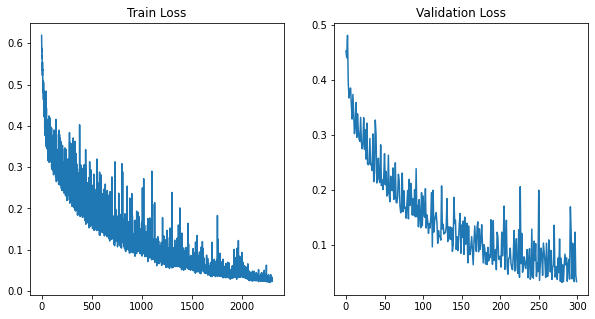

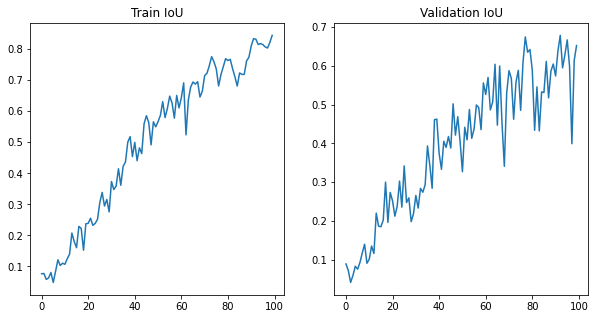

In [12]:
from IPython.display import clear_output


model = UNet(n_channels = 1, n_classes = 1)
model.to(device)
loss3 = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 100
loss_history = []
valid_losses = []
IoU_train = []
IoU_valid = []
for epoch in range(num_epochs):
    print(f'epoch {epoch}')
    dataset = NailsDataset("../input/nails-segmentation/images/", "../input/nails-segmentation/labels/", trans1 = trans1, trans2 = trans2)
    #print(dataset)
    train, val = train_test_split(dataset, train_size=0.9, shuffle=True, random_state=0)
    train_loader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(val, batch_size=2, shuffle=True)
    train_running_loss = 0
    valid_running_loss = 0
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss3(y_pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_history.append(loss.item())
        train_running_loss += loss.item()
    for x1, y1 in valid_loader:
        x1, y1 = x1.to(device), y1.to(device)
        with torch.no_grad():
            y1_pred = model(x1)
            loss1 = loss3(y1_pred, y1)
            valid_losses.append(loss1.item())
            valid_running_loss += loss.item()
    train_running_loss = train_running_loss/len(train_loader)
    print("Train loss - ", train_running_loss)
    valid_running_loss = valid_running_loss/len(valid_loader)
    print("Valid loss - ", valid_running_loss)
    acc_train, IoU_t, acc_t = check_accuracy(train_loader, model)
    IoU_train.append(IoU_t.item())
    print("Mean train accuracy - ", acc_train.item())
    print("Train accuracy - ", acc_t.item())
    acc_valid, IoU_v, acc_v = check_accuracy(valid_loader, model)
    IoU_valid.append(IoU_v.item())
    print("Mean validation accuracy - ", acc_valid.item())
    print("Validation accuracy - ", acc_v.item())
fig, axes = plt.subplots(1, 2)
axes[0].plot(range(len(loss_history)), loss_history)
axes[0].set_title("Train Loss")
axes[1].plot(range(len(valid_losses)), valid_losses)
axes[1].set_title("Validation Loss")
fig.set_figwidth(10)   
fig.set_figheight(5) 
plt.show() 
fig, axes = plt.subplots(1, 2)
axes[0].plot(range(len(IoU_train)), IoU_train)
axes[0].set_title("Train IoU")
axes[1].plot(range(len(IoU_valid)), IoU_valid)
axes[1].set_title("Validation IoU")
fig.set_figwidth(10)   
fig.set_figheight(5) 
plt.show()      

## Test

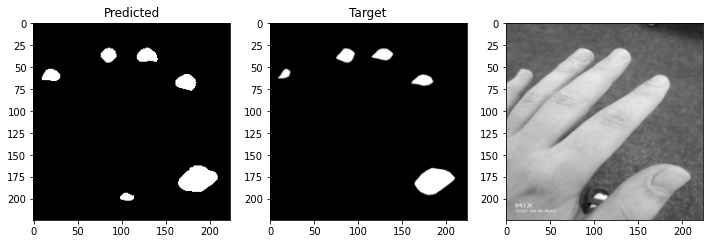

IoU
0.7191524719567927


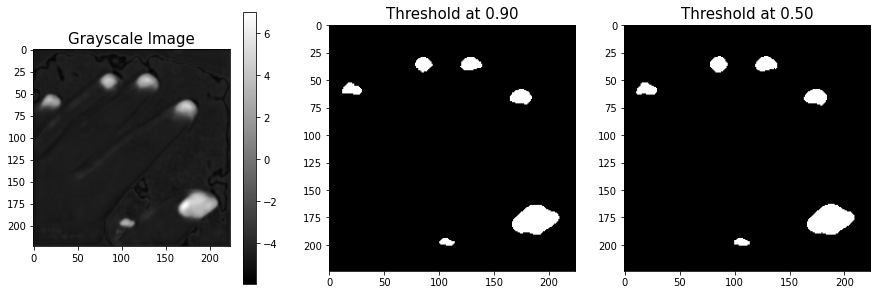

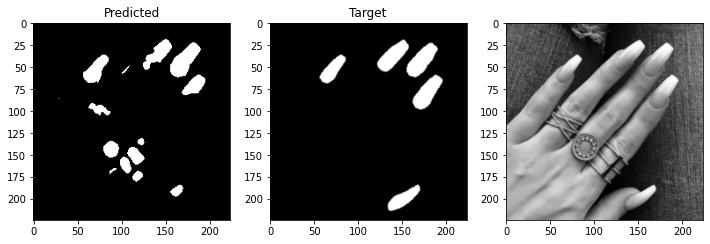

IoU
0.47865459249676584


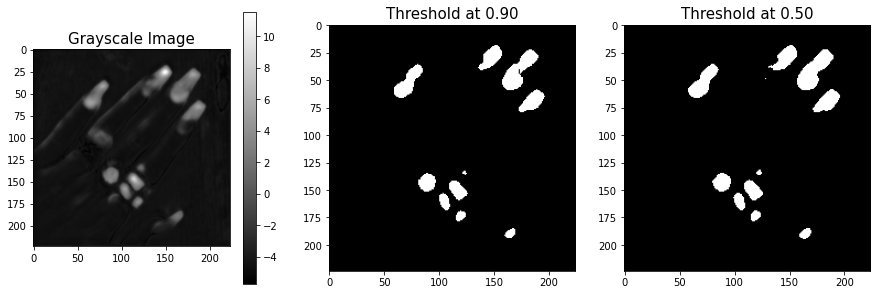

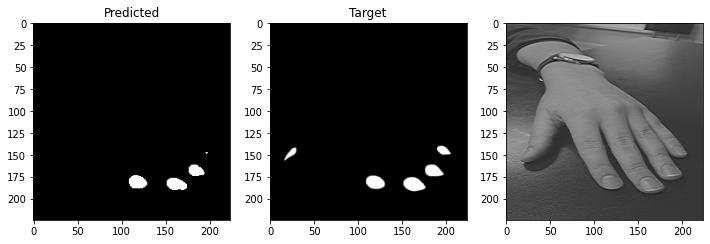

IoU
0.5563665855636658


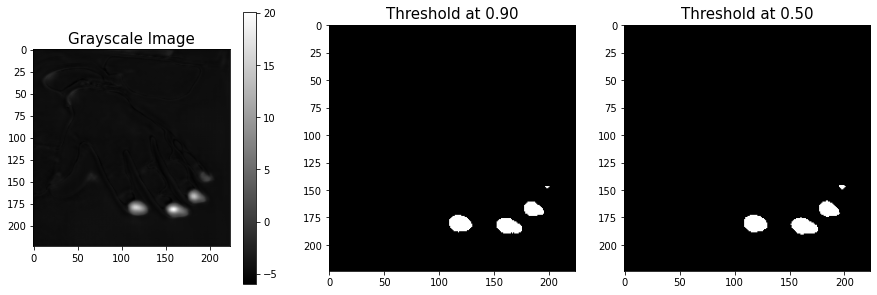

In [13]:
for img, mask in valid_loader:
    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(threshold(model((img).to(device))[0][0].cpu().detach().numpy()), cmap = "gray")
    axes[0].set_title("Predicted")
    axes[1].imshow(((mask).to(device))[0][0].cpu().detach().numpy(), cmap = "gray")
    axes[1].set_title("Target")
    axes[2].imshow(((img).to(device))[0][0].cpu().detach().numpy(), cmap = "gray")
    fig.set_figwidth(12)   
    fig.set_figheight(6)  
    plt.show()
    print("IoU")
    print(iou(((mask).to(device))[0][0].cpu().detach().numpy(),model((img).to(device))[0][0].cpu().detach().numpy()))
    img = model((img).to(device))[0][0].cpu().detach().numpy()
    sample_t = img>0.90
    sample_t1 = img>0.50
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    im = ax[0].imshow(img, cmap = "gray")
    fig.colorbar(im,ax=ax[0])
    ax[1].imshow(sample_t, cmap = "gray")
    ax[0].set_title('Grayscale Image',fontsize=15)
    ax[1].set_title('Threshold at 0.90',fontsize=15)
    ax[2].imshow(sample_t1, cmap = "gray")
    ax[2].set_title('Threshold at 0.50',fontsize=15)
    plt.show()
